In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder\
    .master("local[*]")\
    .appName("Superstore Analysis")\
    .getOrCreate()

In [3]:
from pyspark.sql.types import *

In [4]:
"""
__all__ = [
    "DataType", "NullType", "StringType", "BinaryType", "BooleanType", "DateType",
    "TimestampType", "DecimalType", "DoubleType", "FloatType", "ByteType", "IntegerType",
    "LongType", "ShortType", "ArrayType", "MapType", "StructField", "StructType"]
"""
#create df with structure
schema = StructType([
	StructField("row_id", StringType(), True),
	StructField("order_id", StringType(), True),
	StructField("order_date", StringType(), True),
	StructField("ship_date", StringType(), True),
	StructField("ship_mode", StringType(), True),
	StructField("customer_id", StringType(), True),
	StructField("customer_name", StringType(), True),
	StructField("segment", StringType(), True),
	StructField("country", StringType(), True),
	StructField("city", StringType(), True),
	StructField("state", StringType(), True),
	StructField("postal_code", StringType(), True),
	StructField("region", StringType(), True),
	StructField("product_id", StringType(), True),
	StructField("category", StringType(), True),
	StructField("sub_category", StringType(), True),
	StructField("product_name", StringType(), True),
	StructField("sales", DoubleType(), True),
	StructField("quantity", IntegerType(), True),
	StructField("discount", DoubleType(), True),
	StructField("profit", DoubleType(), True)
])

#create df with structure
superstore_df = spark.read.csv("D:/Work/training/sample_training/Superstores.csv", sep="|", schema=schema, header=None)

In [5]:
#https://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=read%20csv

#create df with inferschema
superstore_df = spark.read.csv("D:/Work/training/sample_training/Superstores.csv", sep="|", inferSchema=True, header=True)

In [6]:
superstore_df.dtypes

[('Row ID', 'int'),
 ('Order ID', 'string'),
 ('Order Date', 'string'),
 ('Ship Date', 'string'),
 ('Ship Mode', 'string'),
 ('Customer ID', 'string'),
 ('Customer Name', 'string'),
 ('Segment', 'string'),
 ('Country', 'string'),
 ('City', 'string'),
 ('State', 'string'),
 ('Postal Code', 'int'),
 ('Region', 'string'),
 ('Product ID', 'string'),
 ('Category', 'string'),
 ('Sub-Category', 'string'),
 ('Product Name', 'string'),
 ('Sales', 'double'),
 ('Quantity', 'int'),
 ('Discount', 'double'),
 ('Profit', 'double')]

In [7]:
#Select dataframe column
superstore_df.select("Order Date").show(3)

+----------+
|Order Date|
+----------+
| 11/8/2016|
| 11/8/2016|
| 6/12/2016|
+----------+
only showing top 3 rows



In [8]:
import datetime

#python cast to date
def castToDate(dates):
    new_dates = datetime.datetime.strptime(dates, '%d/%m/%Y').date()
    return new_dates

#to convert string use .strftime('%Y-%m-%d')

In [9]:
from pyspark.sql.functions import lit, to_date, year, month, dayofmonth

#Convert string to date with specific date format
temp_df = superstore_df\
    .withColumn('Order Date', lit(to_date(superstore_df['Order Date'], 'mm/dd/yyyy')))\
    .withColumn('Ship Date', lit(to_date(superstore_df['Ship Date'], 'mm/dd/yyyy')))

In [10]:
temp_df.select("Order Date").head(3)

[Row(Order Date=datetime.date(2016, 1, 8)),
 Row(Order Date=datetime.date(2016, 1, 8)),
 Row(Order Date=datetime.date(2016, 1, 12))]

In [11]:
import pyspark.sql.functions as F

#function to Concat column in dataframe
def myConcat(*cols):
    return F.concat(*[F.coalesce(c, F.lit("*")) for c in cols])

#Or you can use:
#new_df = temp_df.withColumn('Period', myConcat.concat(year("Order Date"), month("Order Date"))).show()
#new_df = temp_df.withColumn('Period', F.concat(year("Order Date"), month("Order Date"))).show()

In [12]:
"""
dd = (dd.withColumn('month', F.when(F.length(F.col('month')) == 1, F.concat(F.lit('0'), F.col('month'))).otherwise(F.col('month')))
        .withColumn('date', F.when(F.length(F.col('date')) == 1, F.concat(F.lit('0'), F.col('date'))).otherwise(F.col('date')))
        .withColumn('hhmm', F.when(F.length(F.col('hhmm')) == 1, F.concat(F.lit('000'), F.col('hhmm')))
                             .when(F.length(F.col('hhmm')) == 2, F.concat(F.lit('00'), F.col('hhmm')))
                             .when(F.length(F.col('hhmm')) == 3, F.concat(F.lit('0'), F.col('hhmm')))
                             .otherwise(F.col('hhmm')))
        .withColumn('time', F.to_timestamp(F.concat(*dd.columns), format='yyyyMMddHHmm'))
     )
"""
#F.when(F.length(F.col(temp_df.select(month('Order Date')))) == 1, F.concat(F.lit('0'), F.col(temp_df.select(month('Order Date'))))).otherwise(F.col(temp_df.select(month("Order Date"))))

superstore_df = temp_df.withColumn('Period', F.concat(year("Order Date"), month("Order Date")))

In [13]:
superstore_df.show(1)

+------+--------------+----------+----------+------------+-----------+-------------+--------+-------------+---------+--------+-----------+------+---------------+---------+------------+--------------------+------+--------+--------+-------+------+
|Row ID|      Order ID|Order Date| Ship Date|   Ship Mode|Customer ID|Customer Name| Segment|      Country|     City|   State|Postal Code|Region|     Product ID| Category|Sub-Category|        Product Name| Sales|Quantity|Discount| Profit|Period|
+------+--------------+----------+----------+------------+-----------+-------------+--------+-------------+---------+--------+-----------+------+---------------+---------+------------+--------------------+------+--------+--------+-------+------+
|     1|CA-2016-152156|2016-01-08|2016-01-11|Second Class|   CG-12520|  Claire Gute|Consumer|United States|Henderson|Kentucky|      42420| South|FUR-BO-10001798|Furniture|   Bookcases|Bush Somerset Col...|261.96|       2|     0.0|41.9136| 20161|
+------+--------

In [14]:
from pyspark.sql.functions import col, desc

sales_by_period_df = superstore_df \
    .groupBy("Period") \
    .agg({"Sales":"sum"}) \
    .withColumnRenamed("SUM(sales)", "total_sales") \
    .sort(desc("total_sales"))

In [15]:
sales_by_period_df.show()

+------+------------------+
|Period|       total_sales|
+------+------------------+
| 20171| 733215.2551999999|
| 20161| 609205.5980000008|
| 20141| 484247.4981000009|
| 20151|470532.50899999985|
+------+------------------+



In [17]:
sales_by_country_df = superstore_df \
    .groupBy(["Country", "City"]) \
    .agg({"Sales":"sum"}) \
    .withColumnRenamed("SUM(sales)", "total_sales") \
    .sort(desc("total_sales"))

In [18]:
sales_by_country_df.show(5)

+-------------+-------------+------------------+
|      Country|         City|       total_sales|
+-------------+-------------+------------------+
|United States|New York City|        256368.161|
|United States|  Los Angeles|        175851.341|
|United States|      Seattle|        119540.742|
|United States|San Francisco|112669.09199999992|
|United States| Philadelphia|109077.01300000008|
+-------------+-------------+------------------+
only showing top 5 rows



In [71]:
from pyspark.sql.functions import countDistinct

total_segment_df = superstore_df \
    .groupBy("Segment").agg(countDistinct("Order ID").alias("total_order"))

In [72]:
total_segment_df.show()

+-----------+-----------+
|    Segment|total_order|
+-----------+-----------+
|   Consumer|       2586|
|Home Office|        909|
|  Corporate|       1514|
+-----------+-----------+



In [20]:
profit_by_product_df = superstore_df \
    .groupBy("Product Name") \
    .agg({"Profit":"sum"}) \
    .withColumnRenamed("SUM(Profit)", "total_profit") \
    .sort(desc("total_Profit"))

In [21]:
profit_by_product_df.show(5, truncate=False)

+---------------------------------------------------------------------------+------------------+
|Product Name                                                               |total_profit      |
+---------------------------------------------------------------------------+------------------+
|Canon imageCLASS 2200 Advanced Copier                                      |25199.928000000004|
|Fellowes PB500 Electric Punch Plastic Comb Binding Machine with Manual Bind|7753.039          |
|Hewlett Packard LaserJet 3310 Copier                                       |6983.8836         |
|Canon PC1060 Personal Laser Copier                                         |4570.9347         |
|"HP Designjet T520 Inkjet Large Format Printer - 24"" Color"               |4094.9766         |
+---------------------------------------------------------------------------+------------------+
only showing top 5 rows



In [22]:
retur_df = spark.read.csv("D:/Work/training/sample_training/return.csv", sep="|", inferSchema=True, header=True)

In [29]:
retur_df.count()

296

In [43]:
from pyspark.sql.functions import broadcast

total_retur_period_df = retur_df \
    .alias('a')\
    .join(broadcast(superstore_df.alias('b')), col("a.Order ID") == col("b.Order ID"), how="left")\
    .select("a.Order ID", "b.Sales", "b.Quantity", "b.period")\
    .groupBy("Period") \
    .agg({"Sales":"sum", "Quantity":"sum"})\
    .withColumnRenamed("SUM(Sales)","total_retur_sales")\
    .withColumnRenamed("SUM(Quantity)","total_retur_quantity")\
    .sort(desc("Period"))

In [44]:
total_retur_period_df.show()

+------+------------------+--------------------+
|Period| total_retur_sales|total_retur_quantity|
+------+------------------+--------------------+
| 20171| 75502.06389999992|                1140|
| 20161|36121.772000000004|                 790|
| 20151| 39660.89399999997|                 598|
| 20141|29219.547999999984|                 525|
+------+------------------+--------------------+



In [73]:
import pandas as pd
import matplotlib.pyplot as plt

sales_by_period = sales_by_period_df.toPandas()
sales_by_country = sales_by_country_df.toPandas()
profit_by_product = profit_by_product_df.toPandas()
total_segment = total_segment_df.toPandas()
total_retur_period = total_retur_period_df.toPandas()

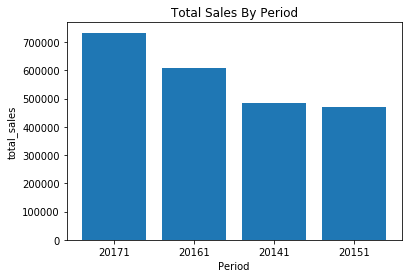

In [64]:
plt.bar(sales_by_period['Period'], sales_by_period['total_sales'])
plt.title("Total Sales By Period")
plt.ylabel('total_sales')
plt.xlabel('Period')
plt.show()

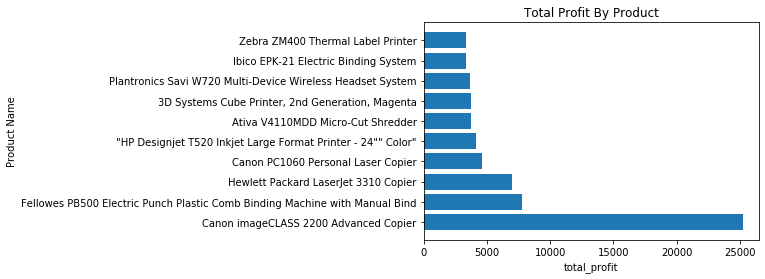

In [86]:
plt.barh(profit_by_product['Product Name'][:10], profit_by_product['total_profit'][:10])
plt.title("Total Profit By Product")
plt.ylabel('Product Name')
plt.xlabel('total_profit')
plt.show()

In [87]:
total_segment.values

array([['Consumer', 2586],
       ['Home Office', 909],
       ['Corporate', 1514]], dtype=object)

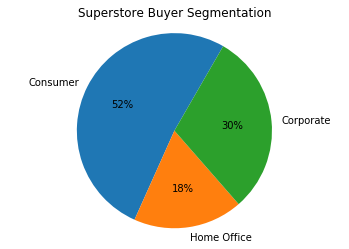

In [89]:
plt.pie(total_segment['total_order'], autopct= '%1.0f%%', labels=total_segment['Segment'], startangle=60)
plt.axis('equal')
plt.title("Superstore Buyer Segmentation")
plt.show()

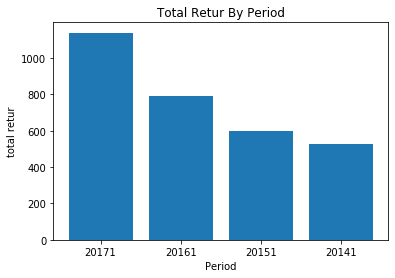

In [91]:
plt.bar(total_retur_period['Period'], total_retur_period['total_retur_quantity'])
plt.title("Total Retur By Period")
plt.xlabel('Period')
plt.ylabel('total retur')
plt.show()